データの前処理

IMDB Dataset
- 映画のレビューコメントを集めた大規模なデータセット
- レビューにはポシティブ(pos:1)かネガティブ(neg:0)のフラグがついている
- 25000件の訓練データ、25000件のテストデータが含まれる

In [1]:
from torchtext.legacy import data #Field
from torchtext.legacy import datasets #IMDB
import torch

TEXT = data.Field(sequential = True, 
                  fix_length = 256, 
                  batch_first = True,
                  lower = True)
LABEL = data.LabelField(sequential = False)

train_all, test_all = datasets.IMDB.splits(TEXT, LABEL)

In [2]:
print(len(train_all))
print(len(test_all))

25000
25000


In [3]:
import random

train_num = 1024
test_num = 128

pos_neg_dic = {
                "pos": 1,
                "neg": 0
}


train = random.sample(
    [(" ".join(text), pos_neg_dic[label]) 
    for (text, label) in zip(train_all.text, train_all.label)],
    train_num
    )
test = random.sample(
    [(" ".join(text), pos_neg_dic[label]) 
    for (text, label) in zip(test_all.text, test_all.label)],
    test_num
    )

In [4]:
print("train")
for tr in train[:3]:
  print(tr[0])
  print(tr[1])
print()
print("test")
for te in test[:3]:
  print(te[0])
  print(te[1])

train
i'd never heard of this movie, but boy was i surprised when i caught it on tv. great cast, great acting. excellent movie! how can a movie with william h macy, neve campbell and donald sutherland go wrong? i wonder why i never heard of it before.
1
kind of hard to believe that the movie from this book could succeed in topping its awfulness! the plot is so contrived and unbelievable. . . starting with laying a ton of guilt on a small child to spare her pain! then we have the collusive behavior of at least six and maybe more people(including clergy) involved in what is a crime everywhere. next we have a wife who seemingly in the length of a ferry ride goes from being comparatively happy to very shortly kicking over the traces. a very unpleasant and coo coo mother, aided, abetted and supported by a politically correct group of friends! moving the setting from an island off the coast of south carolina, did not help the story although it may have helped the film makers budget. the very

In [5]:
import pandas as pd

train = pd.DataFrame(train, columns = ["TEXT_COLUMN", "LABEL_COLUMN"])
test = pd.DataFrame(test, columns = ["TEXT_COLUMN", "LABEL_COLUMN"])

In [6]:
train["LABEL_COLUMN"].value_counts(normalize = True)

1    0.508789
0    0.491211
Name: LABEL_COLUMN, dtype: float64

In [7]:
test["LABEL_COLUMN"].value_counts(normalize = True)

1    0.546875
0    0.453125
Name: LABEL_COLUMN, dtype: float64

In [8]:
!pip install transformers==3.1.0

In [9]:
from transformers import AutoModel, BertTokenizerFast

In [10]:
bert = AutoModel.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [11]:
texts = ["I like spyderman", "I hate this movie"]
input_ids = tokenizer.batch_encode_plus(texts,
                                        padding = True,
                                        return_token_type_ids = True)
print(input_ids)

{'input_ids': [[101, 1045, 2066, 8645, 4063, 2386, 102], [101, 1045, 5223, 2023, 3185, 102, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0]]}


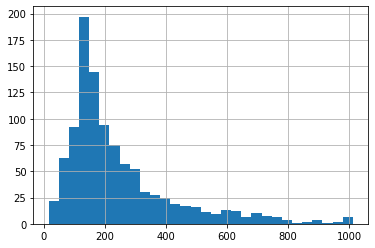

In [12]:
sequence_length = [len(w.split()) for w in train["TEXT_COLUMN"]]
pd.Series(sequence_length).hist(bins = 30)

In [13]:
max_sequence_length = 256

In [14]:
tokens_train = tokenizer.batch_encode_plus(
    train["TEXT_COLUMN"].tolist(),
    max_length = max_sequence_length,
    pad_to_max_length = True,
    truncation = True,
    return_token_type_ids = False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [15]:
tokens_val = tokenizer.batch_encode_plus(
    test["TEXT_COLUMN"].tolist(),
    max_length = max_sequence_length,
    pad_to_max_length = True,
    truncation = True,
    return_token_type_ids = False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [16]:
train_seq = torch.tensor(tokens_train["input_ids"])
train_mask = torch.tensor(tokens_train["attention_mask"])
train_y = torch.tensor(train["LABEL_COLUMN"], dtype = torch.long) 

In [17]:
val_seq = torch.tensor(tokens_val["input_ids"])
val_mask = torch.tensor(tokens_val["attention_mask"])
val_y = torch.tensor(test["LABEL_COLUMN"], dtype = torch.long)

In [18]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [19]:
batch_size = 16

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,
                              sampler = train_sampler,
                              batch_size = batch_size)

In [20]:
batch_size = 16

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data,
                            sampler = val_sampler,
                            batch_size = batch_size)

In [21]:
# Freeze bert parameters
# 転移学習のため

for param in bert.parameters():
  param.requires_grad = False

モデル構築

In [22]:
import torch.nn as nn

class BERTBinaryClassification(nn.Module):
  def __init__(self, bert):
    super().__init__()
    self.bert = bert
    self.dropout = nn.Dropout(0.1)
    self.relu = nn.ReLU()
    self.fc1 = nn.Linear(768, 256) #BERTの最終層の出力の次元は768
    self.fc2 = nn.Linear(256, 2)

  def forward(self, input_ids, attention_mask):
    _, cls_hs = self.bert(input_ids, attention_mask = attention_mask)
    x = self.fc1(cls_hs)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)
    return x

In [23]:
net = BERTBinaryClassification(bert)

In [24]:
device = torch.device("cuda")

In [25]:
net = net.to(device)

In [26]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

class_wts = compute_class_weight("balanced", 
                                 np.unique(train["LABEL_COLUMN"]),
                                 train["LABEL_COLUMN"])
weights = torch.tensor(class_wts, dtype = torch.float)
weights = weights.to(device)

In [27]:
criterion = nn.CrossEntropyLoss(weight = weights)

In [28]:
from transformers import AdamW

optimizer = AdamW(net.parameters(), lr = 1e-3)

In [29]:
import time

def fit():
  net.train()
  total_loss, total_accuracy = 0, 0
  total_preds = []
  t0 = time.time()
  elapsed = 0 #経過時間
  for step, batch in enumerate(train_dataloader):
    if step % 16 == 0 and not step == 0:
      elapsed = time.time() -t0
      print(f"Elapsed Time:{elapsed:.3f}[sec.]")
      print("Batch {:>5} of {:>5}".format(step, len(train_dataloader)))
    batch = [r.to(device) for r in batch]
    input_ids, mask, labels = batch

    net.zero_grad() #AdamWの時はnet.
    preds = net(input_ids, mask)
    loss = criterion(preds, labels)
    total_loss += loss.item()
    loss.backward()
    optimizer.step()

    torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
    preds = preds.detach().cpu().numpy()
    total_preds.append(preds)
  elapsed = time.time() - t0
  print(f"Elapsed Time:{elapsed:.3f}[sec.]")
  avg_loss = total_loss / len(train_dataloader.dataset)
  total_preds = np.concatenate(total_preds, axis = 0)
  return avg_loss, total_preds

In [30]:
def evaluate():
  print("\nEvaluating...")
  net.eval()
  total_loss, total_acc = 0, 0
  total_preds = []
  t0 = time.time()
  elapsed = 0 #経過時間
  for step, batch in enumerate(val_dataloader):
    if step % 16 == 0 and not step == 0:
      elapsed = time.time() -t0
      print(f"Elapsed Time:{elapsed:.3f}[sec.]")
      print("Batch {:>5} of {:>5}".format(step, len(val_dataloader)))
    batch = [r.to(device) for r in batch]
    input_ids, mask, labels = batch

    with torch.no_grad():
      preds = net(input_ids, mask)
      loss = criterion(preds, labels)
      total_loss += loss.item()
      preds = preds.detach().cpu().numpy()
      total_preds.append(preds)
  elapsed = time.time() - t0
  print(f"Elapsed Time:{elapsed:.3f}[sec.]")
  avg_loss = total_loss / len(val_dataloader.dataset)
  total_preds = np.concatenate(total_preds, axis = 0)
  return avg_loss, total_preds

モデル訓練

In [31]:
epochs = 5

best_valid_loss = float('inf')

train_losses = []
val_losses = []

for epoch in range(epochs):
  print(f"\n Epoch:{epoch + 1}/{epochs}")
  train_loss, _ = fit()
  valid_loss, _ = evaluate()

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(net.state_dict(), "saved_weight.pt")
  train_losses.append(train_loss)
  val_losses.append(valid_loss)
  print(f"\nTraining Loss:{train_loss:.3f}")
  print(f"\nValidation Loss:{valid_loss:.3f}")


 Epoch:1/5
Elapsed Time:7.559[sec.]
Batch    16 of    64
Elapsed Time:14.892[sec.]
Batch    32 of    64
Elapsed Time:22.227[sec.]
Batch    48 of    64
Elapsed Time:29.582[sec.]

Evaluating...
Elapsed Time:3.534[sec.]

Training Loss:0.044

Validation Loss:0.042

 Epoch:2/5
Elapsed Time:7.414[sec.]
Batch    16 of    64
Elapsed Time:14.808[sec.]
Batch    32 of    64
Elapsed Time:22.212[sec.]
Batch    48 of    64
Elapsed Time:29.605[sec.]

Evaluating...
Elapsed Time:3.545[sec.]

Training Loss:0.041

Validation Loss:0.040

 Epoch:3/5
Elapsed Time:7.423[sec.]
Batch    16 of    64
Elapsed Time:14.818[sec.]
Batch    32 of    64
Elapsed Time:22.210[sec.]
Batch    48 of    64
Elapsed Time:29.601[sec.]

Evaluating...
Elapsed Time:3.541[sec.]

Training Loss:0.041

Validation Loss:0.041

 Epoch:4/5
Elapsed Time:7.395[sec.]
Batch    16 of    64
Elapsed Time:14.789[sec.]
Batch    32 of    64
Elapsed Time:22.183[sec.]
Batch    48 of    64
Elapsed Time:29.572[sec.]

Evaluating...
Elapsed Time:3.532[se

モデル評価

In [32]:
path = "saved_weight.pt"
net.load_state_dict(torch.load(path))

<All keys matched successfully>

In [34]:
with torch.no_grad():
  preds = net(val_seq.to(device), val_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [35]:
preds.shape

(128, 2)

In [37]:
preds = np.array([np.argmax(pred) for pred in preds])

In [38]:
from sklearn.metrics import classification_report
print(classification_report(val_y, preds))

              precision    recall  f1-score   support

           0       0.64      0.81      0.71        58
           1       0.80      0.61      0.69        70

    accuracy                           0.70       128
   macro avg       0.72      0.71      0.70       128
weighted avg       0.72      0.70      0.70       128



推論

In [50]:
infer_text = ["I like Disney Movie"]
ids_masks = tokenizer.batch_encode_plus(infer_text,
                                        True, 
                                        True, 
                                        True,
                                        256)

In [51]:
ids_masks

{'input_ids': [[101, 1045, 2066, 6373, 3185, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1]]}

In [52]:
input_ids, attention_mask = ids_masks["input_ids"], ids_masks["attention_mask"]

In [53]:
input_ids

[[101, 1045, 2066, 6373, 3185, 102]]

In [54]:
attention_mask

[[1, 1, 1, 1, 1, 1]]

In [55]:
prediction = net(torch.tensor(input_ids).to(device), torch.tensor(attention_mask, dtype = torch.long).to(device))

In [56]:
torch.argmax(prediction).item()

1